<a href="https://colab.research.google.com/github/SockAndSandal/WildfireVisualization/blob/main/model_and_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
from google.colab import files
uploaded = files.upload()

Saving mapdataall_fixed.csv to mapdataall_fixed (2).csv


In [56]:
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
# import geopy
# import folium
# import plotly.graph_objects as go
# import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pickle
og = pd.read_csv(io.BytesIO(uploaded['mapdataall_fixed.csv']))

In [57]:
og.head()

,incident_date_created,incident_date_extinguished,fire_duration,incident_acres_burned,latitude,longitude
0,20171031,20180109,70,37,40.774000,-122.309000
1,20130224,20130228,4,406,36.602575,-118.016510
2,20130420,20130422,2,30,34.288877,-116.941311
3,20130430,20130501,1,274,37.116295,-119.635004
4,20130501,20130509,8,6965,40.190062,-121.595555


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fad73c21cd0>,
      dtype=object)

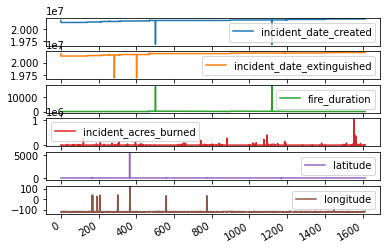

In [58]:
og.plot(subplots=True)

In [59]:
dataset = og.copy()
dataset['date_start'] = pd.to_datetime(dataset['incident_date_created'], format = "%Y%m%d")
dataset['date_end'] = pd.to_datetime(dataset['incident_date_extinguished'], format = "%Y%m%d")
dataset = dataset[['date_start', 'date_end', 'fire_duration', 'incident_acres_burned', 'latitude', 'longitude']]
dataset.head()

,date_start,date_end,fire_duration,incident_acres_burned,latitude,longitude
0,2017-10-31,2018-01-09,70,37,40.774000,-122.309000
1,2013-02-24,2013-02-28,4,406,36.602575,-118.016510
2,2013-04-20,2013-04-22,2,30,34.288877,-116.941311
3,2013-04-30,2013-05-01,1,274,37.116295,-119.635004
4,2013-05-01,2013-05-09,8,6965,40.190062,-121.595555


In [60]:
dataset['StartedMonth'] = [x.month for x in dataset['date_start']]
dataset['ArchiveYear'] = [x.year for x in dataset['date_start']]
monthly_count = dataset.groupby(["ArchiveYear","StartedMonth"])['incident_acres_burned'].count().reset_index()
monthly_count.rename(columns={"incident_acres_burned": "WildfireCount"}, inplace=True)

In [61]:
dates = [x for x in range(2013,2021)]
print(dates)

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [62]:
dataset = dataset[dataset['ArchiveYear'].isin(dates)]

In [63]:
dataset = dataset.sort_values(by='ArchiveYear')

In [64]:
dataset=dataset[['StartedMonth','ArchiveYear','date_start','date_end','fire_duration','incident_acres_burned','latitude','longitude',]]
dataset.head()

,StartedMonth,ArchiveYear,date_start,date_end,fire_duration,incident_acres_burned,latitude,longitude
132,11,2013,2013-11-08,2013-11-09,1,51,35.457978,-120.751555
103,8,2013,2013-08-18,2013-08-24,6,794,35.707000,-118.588000
102,8,2013,2013-08-18,2013-08-25,7,513,40.008420,-120.764666
101,9,2013,2013-09-09,2013-09-15,6,8073,40.498332,-122.535496
100,8,2013,2013-08-17,2013-08-18,1,110,34.287000,-117.451000


In [65]:
# Location cleanup
dataset.drop(dataset[dataset['longitude'] < -124].index, inplace = True) # -124 to -114
dataset.drop(dataset[dataset['longitude'] > -110].index, inplace = True) # -124 to -114
dataset.drop(dataset[dataset['latitude'] > 50].index, inplace = True)
dataset.drop(dataset[dataset['latitude'] < 20].index, inplace = True)

In [66]:
dataset.reset_index(drop=True, inplace=True)

In [67]:
dataset = dataset.drop(['date_end'], axis=1)
dataset.head(-10)

,StartedMonth,ArchiveYear,date_start,fire_duration,incident_acres_burned,latitude,longitude
0,11,2013,2013-11-08,1,51,35.457978,-120.751555
1,8,2013,2013-08-18,6,794,35.707000,-118.588000
2,8,2013,2013-08-18,7,513,40.008420,-120.764666
3,9,2013,2013-09-09,6,8073,40.498332,-122.535496
4,8,2013,2013-08-17,1,110,34.287000,-117.451000
...,...,...,...,...,...,...,...
1579,6,2020,2020-06-22,1,15,35.629060,-120.683260
1580,6,2020,2020-06-23,3,19,36.975110,-119.334390
1581,6,2020,2020-06-23,3,563,40.432030,-120.281470
1582,6,2020,2020-06-24,2,210,40.447930,-120.046350


In [68]:
join_df=pd.DataFrame({
        'from':  [ 1, 11, 5, 3, 9],
        'to':    [3, 12, 8, 4, 10],
        'label': ['winter', 'winter', 'summer', 'spring', 'fall']
    })
join_df.sort_values('from', axis='index', inplace=True)
max_tolerance=(join_df['to'] - join_df['from']).max()
dataset.sort_values(by='StartedMonth', inplace=True)
result= pd.merge_asof(dataset, join_df, left_on='StartedMonth', right_on='from', direction='backward', tolerance=max_tolerance)
result.loc[result['to']<result['StartedMonth'], 'label']= np.NaN
result.drop(['from', 'to'], axis='columns', inplace=True)
dataset = result

In [69]:
# dataset.sort_values(by='ArchiveYear', inplace=True)
dataset.reset_index(drop=True, inplace=True)
dataset.rename(columns={"label":"season", "ArchiveYear":"year_start", "StartedMonth":"month_start"},inplace=True)

In [70]:
dataset = pd.get_dummies(dataset)
dataset.head(-20)

,month_start,year_start,date_start,fire_duration,incident_acres_burned,latitude,longitude,season_fall,season_spring,season_summer,season_winter
0,1,2014,2014-01-25,1,106,36.826600,-119.341500,0,0,0,1
1,1,2014,2014-01-16,11,1952,34.170300,-117.881600,0,0,0,1
2,1,2014,2014-01-04,4,333,40.884415,-123.773779,0,0,0,1
3,1,2019,2019-01-01,14,30,40.618056,-123.675556,0,0,0,1
4,1,2014,2014-01-02,8,865,40.134597,-121.790183,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1569,11,2018,2018-11-08,57,1500,38.213960,-121.942400,0,0,0,1
1570,11,2018,2018-11-08,57,4531,34.226850,-118.934440,0,0,0,1
1571,11,2018,2018-11-08,57,96949,34.235000,-118.701280,0,0,0,1
1572,11,2019,2019-11-01,0,19,33.849906,-117.461363,0,0,0,1


In [71]:
dataset.describe()

,month_start,year_start,fire_duration,incident_acres_burned,latitude,longitude,season_fall,season_spring,season_summer,season_winter
count,1594.000000,1594.000000,1594.000000,1.594000e+03,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000
mean,7.337516,2017.134253,79.521957,4.599281e+03,37.239709,-120.277046,0.207026,0.025094,0.721455,0.046424
std,1.757491,2.000199,88.834476,3.494532e+04,2.574849,1.992084,0.405302,0.156460,0.448423,0.210468
min,1.000000,2013.000000,0.000000,0.000000e+00,26.420000,-123.968440,0.000000,0.000000,0.000000,0.000000
25%,6.000000,2016.000000,2.000000,3.500000e+01,34.918382,-121.813866,0.000000,0.000000,0.000000,0.000000
50%,7.000000,2017.000000,16.000000,1.000000e+02,37.437719,-120.703709,0.000000,0.000000,1.000000,0.000000
75%,8.000000,2019.000000,167.000000,4.472500e+02,39.296303,-118.747164,0.000000,0.000000,1.000000,0.000000
max,12.000000,2020.000000,366.000000,1.032648e+06,44.734000,-114.572650,1.000000,1.000000,1.000000,1.000000


In [72]:
dataset.nunique()

month_start                12
year_start                  8
date_start                828
fire_duration             243
incident_acres_burned     655
latitude                 1578
longitude                1581
season_fall                 2
season_spring               2
season_summer               2
season_winter               2
dtype: int64

In [73]:
dataset.drop(columns=['latitude','longitude'], inplace=True)
dataset.head(-10)

,month_start,year_start,date_start,fire_duration,incident_acres_burned,season_fall,season_spring,season_summer,season_winter
0,1,2014,2014-01-25,1,106,0,0,0,1
1,1,2014,2014-01-16,11,1952,0,0,0,1
2,1,2014,2014-01-04,4,333,0,0,0,1
3,1,2019,2019-01-01,14,30,0,0,0,1
4,1,2014,2014-01-02,8,865,0,0,0,1
...,...,...,...,...,...,...,...,...,...
1579,12,2020,2020-12-01,11,1087,0,0,0,1
1580,12,2020,2020-12-02,1,0,0,0,0,1
1581,12,2017,2017-12-05,44,6049,0,0,0,1
1582,12,2017,2017-12-05,244,15619,0,0,0,1


In [74]:
X = dataset.drop(columns=['fire_duration','date_start']).values
y = dataset.fire_duration.values

In [75]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=23)

In [76]:
rf3 = RandomForestRegressor(n_estimators=3000)
rf3.fit(X_train,y_train)

# Save to file in the current working directory
pkl_filename = "fireduration_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf3, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test)


Test score: 95.60 %


In [77]:
dataset.to_csv(r'predicted_data.csv',index=False)

In [78]:
df = dataset.sample(frac = 0.4)
df.sort_values(by='year_start',inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,month_start,year_start,date_start,fire_duration,incident_acres_burned,season_fall,season_spring,season_summer,season_winter
0,5,2013,2013-05-01,3,3166,0,0,1,0
1,10,2013,2013-10-04,1,305,1,0,0,0
2,8,2013,2013-08-05,4,1383,0,0,1,0
3,5,2013,2013-05-03,0,354,0,0,1,0
4,7,2013,2013-07-23,0,45,0,0,1,0


In [79]:
np.random.seed(23)
df['year_start'] = np.random.randint(2021,2025, size=len(df))
df['month_start'] = np.random.randint(1,13,size=len(df))
df.drop(columns='date_start',inplace=True)
# df.drop(columns=['ArchiveYear','StartedMonth'], inplace=True)
df.head()

,month_start,year_start,fire_duration,incident_acres_burned,season_fall,season_spring,season_summer,season_winter
0,4,2024,3,3166,0,0,1,0
1,9,2023,1,305,1,0,0,0
2,7,2021,4,1383,0,0,1,0
3,5,2022,0,354,0,0,1,0
4,9,2023,0,45,0,0,1,0


In [80]:
X_pred = df.drop(columns=['fire_duration']).values
print(X_pred)

[[   4 2024 3166 ...    0    1    0]
 [   9 2023  305 ...    0    0    0]
 [   7 2021 1383 ...    0    1    0]
 ...
 [   6 2024  230 ...    0    0    0]
 [   2 2021  129 ...    0    1    0]
 [   7 2023  250 ...    0    1    0]]


In [81]:
Y_pred = pickle_model.predict(X_pred)
print(Y_pred)

[12.29333333  1.21833333  3.92233333  3.82466667  2.79507778  4.27866349
  1.00507222  3.75216111  2.48211111  4.3162      1.01247222  3.59833333
  1.4455      1.92980556  2.123       2.53156508  1.62933333 12.01533333
  6.88267778  4.72966667  5.28866667  2.58292143  2.2978381   2.32936508
 50.14966667 17.428       1.7601      1.58821984  1.48060476  1.05466667
  5.046       2.70892249  2.54688254  6.04733333 26.67301429  1.35459444
 19.918      43.16966667  0.91717143  5.72536667  1.1698127   5.73266667
  2.33622222  5.46343889  1.87616667  6.86136667  0.96201667 12.88166667
  2.06450556  5.2372     10.78333333  5.81966667 16.681       1.53671984
  7.0031      1.67586825 13.64566667  6.38433333  6.48366667  2.5927
  3.0306      1.13722421  1.44370278  6.51486667  8.196       1.82185926
 28.229       4.85333333  6.18033333  2.40594762 12.56066667 39.55733333
 15.537       0.77819444  1.42950794  2.94526667  4.48166667 23.53066667
  2.28669444  2.243      28.39081508  1.6405627   0.914

In [82]:
df['predicted_fire_duration'] = Y_pred.round()

In [83]:
df.head(-10)

,month_start,year_start,fire_duration,incident_acres_burned,season_fall,season_spring,season_summer,season_winter,predicted_fire_duration
0,4,2024,3,3166,0,0,1,0,12.0
1,9,2023,1,305,1,0,0,0,1.0
2,7,2021,4,1383,0,0,1,0,4.0
3,5,2022,0,354,0,0,1,0,4.0
4,9,2023,0,45,0,0,1,0,3.0
...,...,...,...,...,...,...,...,...,...
623,2,2023,0,13,0,0,1,0,1.0
624,11,2022,8,5513,0,0,1,0,13.0
625,2,2023,4,445,0,0,1,0,6.0
626,12,2022,22,120,0,0,1,0,6.0


In [85]:
df.describe()

,month_start,year_start,fire_duration,incident_acres_burned,season_fall,season_spring,season_summer,season_winter,predicted_fire_duration
count,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000
mean,6.443574,2022.440439,79.515674,3827.697492,0.211599,0.026646,0.711599,0.050157,5.608150
std,3.442615,1.127115,89.851276,24029.453050,0.408762,0.161172,0.453374,0.218440,7.547655
min,1.000000,2021.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,2021.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,6.000000,2022.000000,15.500000,94.500000,0.000000,0.000000,1.000000,0.000000,3.000000
75%,9.000000,2023.000000,167.750000,367.500000,0.000000,0.000000,1.000000,0.000000,6.000000
max,12.000000,2024.000000,358.000000,396624.000000,1.000000,1.000000,1.000000,1.000000,50.000000


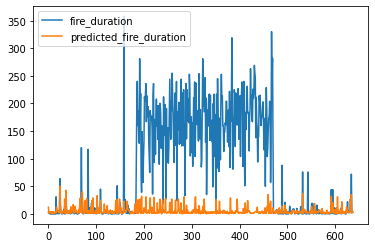

In [84]:
df[['fire_duration','predicted_fire_duration']].plot()

In [86]:
df['predicted_fire_duration'] = df['fire_duration']
df.drop(columns=['predicted_fire_duration'], inplace=True)

In [52]:
final = pd.concat([dataset,df])
final.sort_values(by='year_start',inplace=True)
final.drop(columns='date_start', inplace=True)
final.reset_index(drop=True,inplace=True)
final.head()

,month_start,year_start,fire_duration,incident_acres_burned,season_fall,season_spring,season_summer,season_winter
0,5,2013,3,3166,0,0,1,0
1,5,2013,1,91,0,0,1,0
2,5,2013,8,6965,0,0,1,0
3,5,2013,2,125,0,0,1,0
4,7,2013,0,492,0,0,1,0


In [53]:
final.head(-20)

,month_start,year_start,fire_duration,incident_acres_burned,season_fall,season_spring,season_summer,season_winter
0,5,2013,3,3166,0,0,1,0
1,5,2013,1,91,0,0,1,0
2,5,2013,8,6965,0,0,1,0
3,5,2013,2,125,0,0,1,0
4,7,2013,0,492,0,0,1,0
...,...,...,...,...,...,...,...,...
2207,3,2024,263,15,0,1,0,0
2208,2,2024,12,12466,1,0,0,0
2209,5,2024,366,4016,0,0,1,0
2210,11,2024,2,1651,0,0,1,0


In [87]:
final.to_csv('prediction_wildfire_duration.csv')
dataset.to_csv('13-20_data.csv')
df.to_csv('21-24_data.csv')

In [5]:
upload = files.upload()

Saving prediction_wildfire_duration.csv to prediction_wildfire_duration.csv


In [15]:

final = pd.read_csv(io.BytesIO(upload['prediction_wildfire_duration.csv']))
final.head()

,Unnamed: 0,month_start,year_start,fire_duration,incident_acres_burned,season_fall,season_spring,season_summer,season_winter
0,0,7,2013,0,492,0,0,1,0
1,1,5,2013,3,2781,0,0,1,0
2,2,8,2013,0,27,0,0,1,0
3,3,5,2013,1,40,0,0,1,0
4,4,8,2013,9,1070,0,0,1,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fad77b13d10>,
      dtype=object)

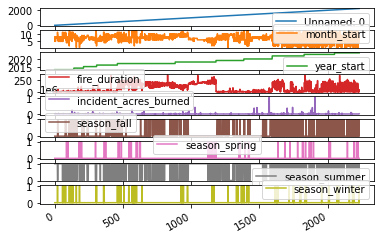

In [20]:
final.plot(subplots=True)